# 1. Introduction
Quick exploratory data analysis of [Netflix](https://www.kaggle.com/shivamb/netflix-shows) dataset.<br>
The aim of this notebook is to visualize and analyze the Netflix data.<br>
**If you're reading this, please upvote.**

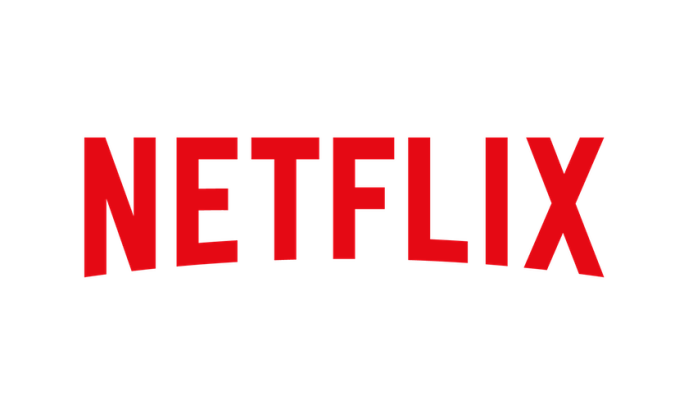

In [1]:
# libraries
import random
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings; warnings.filterwarnings("ignore")

# unhide all rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# for character encoding
import chardet

# for box-cox transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Data Loading
The following lines prevent some errors while loading data, delete them from the code and check for yourselves:
* encoding="latin-1"
* delimiter=","

Dataset is ranked according to "show_id" column.

In [2]:
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv", delimiter=",", encoding="latin-1", parse_dates=["date_added"], index_col=["show_id"])
df

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...
s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...


So, there are 8807 rows with 12 columns.<br>
Check the data types first.

In [3]:
df.dtypes

type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object

"show_id" looks same with the index so we can just index it. <br>
Also, "date_added" and "release_year" were not defined as date. <br>
All can be fixed by adding *parse_dates* and *index_col* to read_csv line.

# 3. Data Cleaning

"data_added" is in "YYYY-MM-DD" format.<br>
Since "release_year" is in "YYYY" format, it would look better to equalize the formats.

In [4]:
df["date_added"] = df["date_added"].dt.year
df["date_added"].unique()

array([2021., 2020., 2019., 2018., 2017., 2016., 2015., 2014., 2013.,
       2012., 2011., 2009., 2008.,   nan, 2010.])

In [5]:
df["date_added"].fillna(0, inplace=True)
df["date_added"] = df["date_added"].astype(int)
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Before moving on, have a look at the shows/movies without "date_added".

In [6]:
# df[df["date_added"]==0]
df.loc[df["date_added"]==0, ]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s6067,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,0,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
s6175,TV Show,Anthony Bourdain: Parts Unknown,NaN,Anthony Bourdain,United States,0,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
s6796,TV Show,Frasier,NaN,"Kelsey Grammer, Jane Leeves, David Hyde Pierce...",United States,0,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...
s6807,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,0,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...
s6902,TV Show,Gunslinger Girl,NaN,"Yuuka Nanri, Kanako Mitsuhashi, Eri Sendai, Am...",Japan,0,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe..."
s7197,TV Show,Kikoriki,NaN,Igor Dmitriev,NaN,0,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...
s7255,TV Show,La Familia P. Luche,NaN,"Eugenio Derbez, Consuelo Duval, Luis Manuel Ã...",United States,0,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder..."
s7407,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,0,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
s7848,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason SaldaÃ±a, Gustavo Sorola, ...",United States,0,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."


Nice. Now, check how many NaN values in other columns.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8807 entries, s1 to s8807
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          8807 non-null   object
 1   title         8807 non-null   object
 2   director      6173 non-null   object
 3   cast          7982 non-null   object
 4   country       7976 non-null   object
 5   date_added    8807 non-null   int64 
 6   release_year  8807 non-null   int64 
 7   rating        8803 non-null   object
 8   duration      8804 non-null   object
 9   listed_in     8807 non-null   object
 10  description   8807 non-null   object
dtypes: int64(2), object(9)
memory usage: 825.7+ KB


In [8]:
# check for duplicate rows
df.duplicated().sum()

0

No duplicate rows, that's good.<br>
We can fill the null values with "No Data" to prevent problems in visualization.

In [9]:
df.fillna("No Data", inplace=True)
df.isnull().sum()

type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

# 4. Exploratory Data Analysis

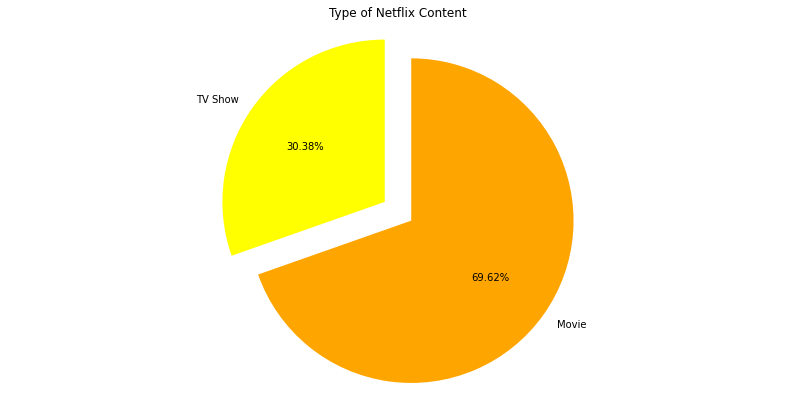

In [10]:
plt.figure(figsize=(14, 7))
labels=['TV Show', 'Movie']
plt.pie(df['type'].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['yellow','orange'], startangle=90)
plt.title('Type of Netflix Content')
plt.axis('equal')
plt.show()

Almost 70% of the content on netflix are movies.

In [11]:
country_df = df['country'].value_counts().reset_index()
country_df = country_df[country_df['country'] /  country_df['country'].sum() > 0.01]

fig = px.pie(country_df, values='country', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

United States is the lead content creator as expected. <br>
And, India is the second. I was expecting United Kingdom frankly.

In [12]:
df = df.reset_index()
released_year_df = df.loc[df['release_year'] > 2000].groupby(['release_year', 'type']).agg({'show_id': 'count'}).reset_index()
added_year_df = df.loc[df['date_added'] > 2000].groupby(['date_added', 'type']).agg({'show_id': 'count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'Movie']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Released Year',
    marker_color='orange',
))
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'TV Show']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Released Year',
    marker_color='red',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'Movie']['date_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Year Added',
    marker_color='yellow',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'TV Show']['date_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Year Added',
    marker_color='greenyellow',
))
fig.update_xaxes(categoryorder='total descending')
fig.show()

The reason why all movies and TV shows were added after 2008 is that Netflix was established in 2008. <br>
As of 2017, many more (almost twice as many) movies than TV shows have been added to the platform each year.

# 5. Conclusion

There is much more to dig deep but these can be summarized as general inference.

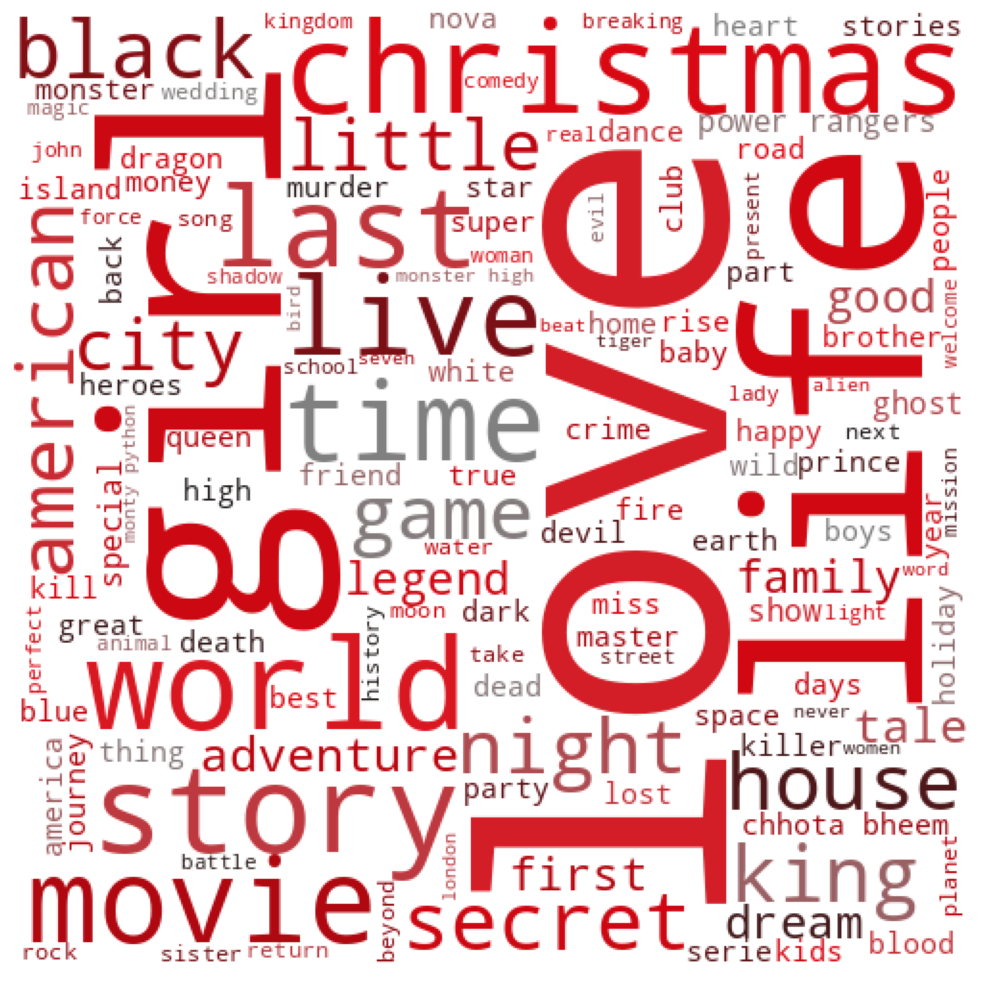

In [13]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 

for word in df.title:
    words = word.split(',')
    for i in words:
        token = i.lower()
        comment_words += "".join(token) + ' '

colors = ['#221f1f', '#b20710', '#e50914','grey']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_word_length = 4,
                stopwords = stopwords, colormap = colormap,
                min_font_size = 10).generate(comment_words) 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()